<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 4: Modelling of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

###### References

1. https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.
2. https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec
3. https://www.dataquest.io/blog/understanding-regression-error-metrics/ 
4. https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/
5. https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret
6. https://pycaret.readthedocs.io/en/latest/api/regression.html
7. http://www.pycaret.org/tutorials/html/REG102.html
8. https://githubhelp.com/ray-project/tune-sklearn

## Check PyCaret Version

In [1]:
from pycaret.utils import version

In [2]:
version()

'2.3.6'

#### Libraries

In [3]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

#!pip install natsort --user
#!pip install xlrd --user
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user
#!pip install redis --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [4]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final\2_GOM_MODEL'
filename_suffix = 'csv'

##### Read in the data 

In [5]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfBOEMGOM.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF
0,PLL,1315672,3700,7.94,255,WTR,0.35,0.16,1997,1750,118.33,190,24,1.120,0.32
1,PLL,4070162,3800,62.09,86,WTR,0.32,0.16,1416,1797,119.33,239,25,1.124,0.41
2,PLL,6586236,3800,67.83,169,WTR,0.32,0.16,1416,1797,119.33,239,25,1.124,0.31
3,PLL,59160,4775,5.00,40,WTR,0.35,0.31,364,2254,123.33,379,30,1.189,0.19
4,PU,3724947,5249,15.47,360,WTR,0.34,0.28,415,2477,138.33,309,23,1.112,0.46


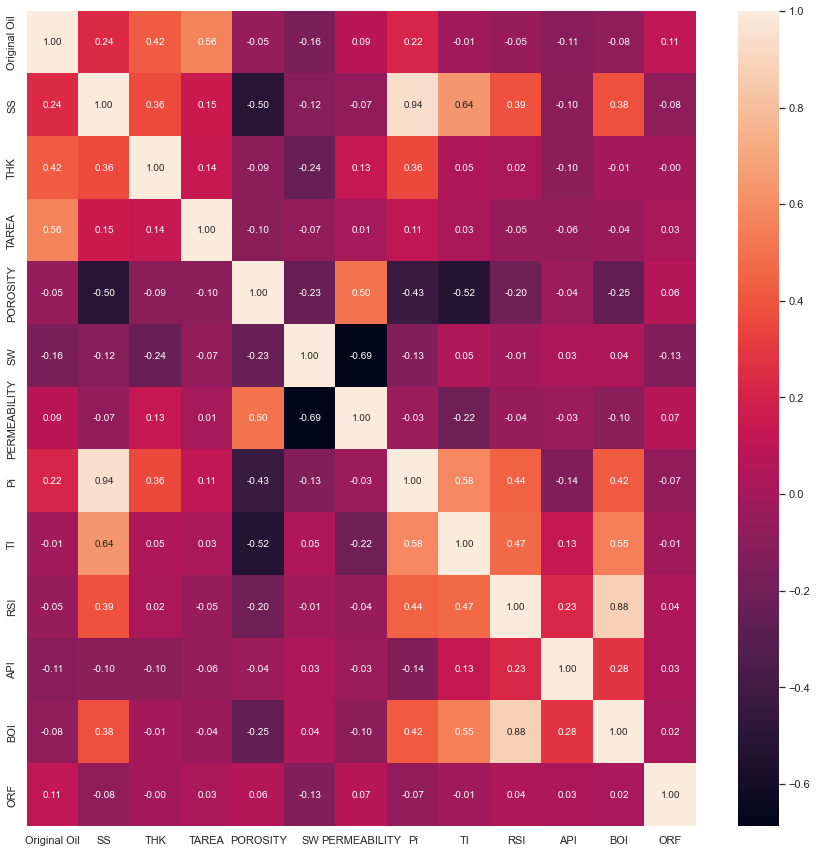

In [6]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. There was no highly correlated values

##### Convert to float - to ensure it is a numerical feature

In [7]:
df_drop = df.copy()
#df_drop = df_drop.astype(float)
df_drop = df_drop[df_drop['ORF']<0.51]

# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

3945
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3945 entries, 0 to 4511
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CHRONOZONE    3945 non-null   object 
 1   Original Oil  3945 non-null   int64  
 2   SS            3945 non-null   int64  
 3   THK           3945 non-null   float64
 4   TAREA         3945 non-null   int64  
 5   DRIVE         3945 non-null   object 
 6   POROSITY      3945 non-null   float64
 7   SW            3945 non-null   float64
 8   PERMEABILITY  3945 non-null   int64  
 9   Pi            3945 non-null   int64  
 10  TI            3945 non-null   float64
 11  RSI           3945 non-null   int64  
 12  API           3945 non-null   int64  
 13  BOI           3945 non-null   float64
 14  ORF           3945 non-null   float64
dtypes: float64(6), int64(7), object(2)
memory usage: 493.1+ KB
None
       CHRONOZONE  Original Oil            SS          THK         TAREA  \
count       

Final Data set has 3945 rows and 15 columns.

### Train, Validation, and Test Split

In [8]:
# Creates a mask where values that are true go into the training/test set
# Note that I done it so that the random number is predictable

msk = np.random.seed(0)
msk = np.random.rand(len(df_drop))<0.8

raw_train_validate_set = df_drop[msk]
raw_test_set = df_drop[~msk]

print(raw_train_validate_set.shape)
print(raw_test_set.shape)

(3134, 15)
(811, 15)


In [9]:
raw_train_validate_set.to_excel(r'dfssoil.xlsx', index = False, header=True)
raw_test_set.to_excel(r'BlindTest_SSOILv2.xlsx', index = False, header=True)

We split the data set 80-20 into a "train-validate" set and a "test" set. The test set is external asn will never be seen by the model.

## 1. Pycaret Implementation

Pycaret will be used in the machine learning portion. Pycaret is a low-code machine learning library in Python that automates machine learning workflows. One of its key benefits is its ability to run a large number of differnt machine learning algorithms, but with only a few lines of code

In [10]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF
0,PLL,1315672,3700,7.94,255,WTR,0.35,0.16,1997,1750,118.33,190,24,1.120,0.32
1,PLL,4070162,3800,62.09,86,WTR,0.32,0.16,1416,1797,119.33,239,25,1.124,0.41
2,PLL,6586236,3800,67.83,169,WTR,0.32,0.16,1416,1797,119.33,239,25,1.124,0.31
3,PLL,59160,4775,5.00,40,WTR,0.35,0.31,364,2254,123.33,379,30,1.189,0.19
4,PU,3724947,5249,15.47,360,WTR,0.34,0.28,415,2477,138.33,309,23,1.112,0.46


In [11]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = 'ORF'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            transformation = True,
            ignore_low_variance=True,
            remove_outliers = True, #outliers_threshold = 0.1,
            #remove_multicollinearity = True, multicollinearity_threshold = 0.7,
            train_size=0.7)

,Description,Value
0,session_id,42
1,Target,ORF
2,Original Data,"(3945, 15)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2623, 28)"


In [12]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0733,0.0088,0.0935,0.5608,0.0740,0.5742,0.0600
gbr,Gradient Boosting Regressor,0.0785,0.0094,0.0968,0.5304,0.0767,0.6612,0.0740
catboost,CatBoost Regressor,0.0637,0.0074,0.0817,0.5281,0.0645,0.5067,0.7450
rf,Random Forest Regressor,0.0790,0.0096,0.0978,0.5198,0.0776,0.6987,0.2080
et,Extra Trees Regressor,0.0800,0.0099,0.0994,0.5041,0.0789,0.7403,0.1360
xgboost,Extreme Gradient Boosting,0.0779,0.0099,0.0994,0.5035,0.0788,0.6272,0.1770
br,Bayesian Ridge,0.0924,0.0132,0.1147,0.3408,0.0920,1.0621,0.0040
ridge,Ridge Regression,0.0923,0.0132,0.1148,0.3400,0.0920,1.0582,0.0040
lr,Linear Regression,0.0923,0.0132,0.1148,0.3397,0.0920,1.0578,0.4130
huber,Huber Regressor,0.0917,0.0133,0.1154,0.3319,0.0926,1.0414,0.0140


In [13]:
top3_fold_5 = compare_models(include=['rf', 'catboost', 'knn'], fold = 5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0718,0.0084,0.0917,0.5789,0.0725,0.5775,0.7220
rf,Random Forest Regressor,0.0795,0.0097,0.0986,0.5142,0.0782,0.7046,0.1880
knn,K Neighbors Regressor,0.1102,0.0183,0.1351,0.0875,0.1085,1.3593,0.0160


In [14]:
top3 = compare_models(include=['rf', 'catboost', 'knn'], fold = 10, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0708,0.0082,0.0906,0.5885,0.0716,0.5650,0.8500
rf,Random Forest Regressor,0.0790,0.0096,0.0978,0.5198,0.0776,0.6987,0.1970
knn,K Neighbors Regressor,0.1091,0.0179,0.1339,0.1022,0.1075,1.3399,0.0090


There is a performance improvement in going from 5 folds to 10 folds for all 3 models. To keep computation time reasonable, folds is kept at 10.

## 2. Plot each Model and Check Features

##### Gradient Boost (GBR)

In [15]:
gbr = create_model('gbr')
gbr_results = pull()
#print(gbr_results)

gbr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(gbr.feature_importances_)}).sort_values(by='Value', ascending=False)
gbr_feature_imp.to_csv('Feature_importance_GBR.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0813,0.0101,0.1003,0.5052,0.0795,0.6434
1,0.0774,0.0090,0.0946,0.5475,0.0757,0.6474
2,0.0772,0.0096,0.0977,0.4769,0.0773,0.6358
3,0.0729,0.0081,0.0902,0.5660,0.0719,0.6451
4,0.0786,0.0092,0.0959,0.5157,0.0761,0.7530
5,0.0803,0.0091,0.0954,0.5601,0.0760,0.6717
6,0.0749,0.0089,0.0942,0.5632,0.0741,0.6328
7,0.0802,0.0100,0.1002,0.5351,0.0787,0.6852
8,0.0817,0.0098,0.0989,0.5367,0.0785,0.6698
9,0.0804,0.0101,0.1004,0.4971,0.0796,0.6274


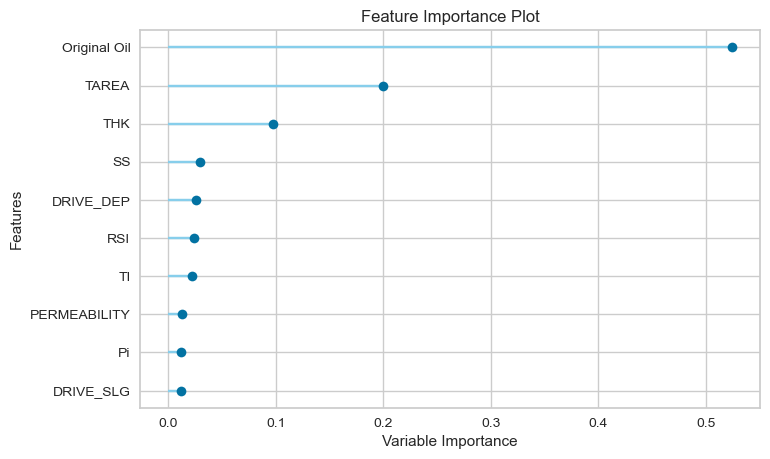

In [16]:
plot_model(gbr, plot = 'feature')

##### Random Forest (RFR)

In [17]:
rfr = create_model('rf')
rfr_results = pull()

rfr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(rfr.feature_importances_)}).sort_values(by='Value', ascending=False)
rfr_feature_imp.to_csv('Feature_importance_RFR.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0844,0.0107,0.1037,0.4716,0.0821,0.7242
1,0.0810,0.0095,0.0972,0.5227,0.0778,0.6994
2,0.0776,0.0097,0.0983,0.4710,0.0776,0.6816
3,0.0715,0.0080,0.0896,0.5714,0.0715,0.6391
4,0.0801,0.0100,0.1000,0.4730,0.0793,0.8208
5,0.0787,0.0088,0.0941,0.5720,0.0750,0.6839
6,0.0746,0.0088,0.0937,0.5683,0.0739,0.6553
7,0.0806,0.0103,0.1017,0.5207,0.0801,0.7246
8,0.0804,0.0098,0.0989,0.5374,0.0786,0.7091
9,0.0815,0.0102,0.1012,0.4897,0.0802,0.6493


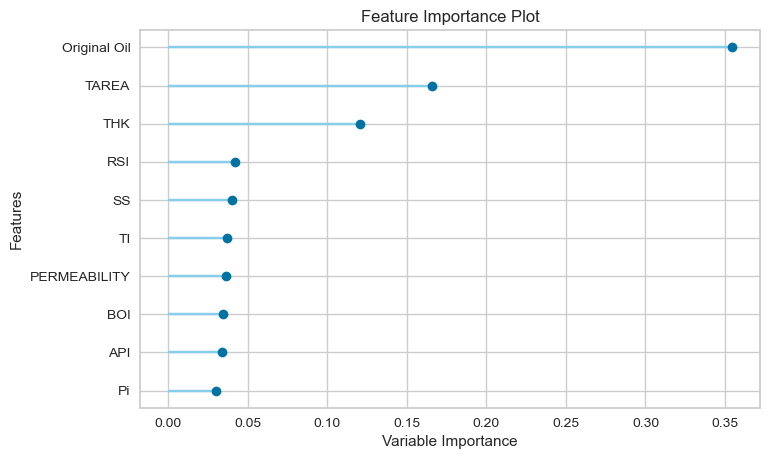

In [18]:
plot_model(rfr, plot = 'feature')

##### Catboost Regressor (catboost)

In [19]:
cb = create_model('catboost')
cb_results = pull()

cb_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(cb.feature_importances_)}).sort_values(by='Value', ascending=False)
cb_feature_imp.to_csv('Feature_importance_CatBoost.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0723,0.0086,0.0929,0.5756,0.0739,0.5847
1,0.0714,0.0078,0.0886,0.6039,0.0707,0.5835
2,0.0709,0.0088,0.0941,0.5155,0.0738,0.5639
3,0.0645,0.0069,0.0828,0.6346,0.0654,0.5127
4,0.0722,0.0083,0.0910,0.5637,0.0719,0.5948
5,0.0731,0.0083,0.0911,0.5984,0.0718,0.6234
6,0.0678,0.0078,0.0882,0.6178,0.0695,0.5694
7,0.0725,0.0087,0.0932,0.5980,0.0730,0.5706
8,0.0709,0.0085,0.0920,0.5992,0.0729,0.5325
9,0.0724,0.0085,0.0920,0.5780,0.0727,0.5150


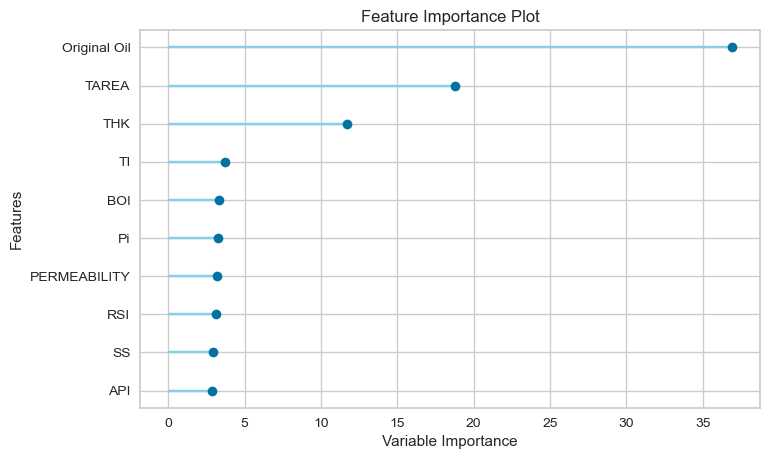

In [20]:
plot_model(cb, plot = 'feature')

##### Light Gradient Boosting Machine Regressor (lightgbm)

In [21]:
lgbm = create_model('lightgbm')
lgbm_results = pull()

lgbm_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(lgbm.feature_importances_)}).sort_values(by='Value', ascending=False)
lgbm_feature_imp.to_csv('Feature_importance_LGBM.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0748,0.0091,0.0953,0.5534,0.0758,0.6226
1,0.0739,0.0085,0.0922,0.5705,0.0737,0.5954
2,0.0769,0.0097,0.0984,0.4695,0.0776,0.5716
3,0.0668,0.0073,0.0856,0.6090,0.0678,0.4991
4,0.0757,0.0092,0.0961,0.5140,0.0756,0.5988
5,0.0729,0.0084,0.0915,0.5951,0.0730,0.6164
6,0.0675,0.0078,0.0883,0.6161,0.0693,0.5320
7,0.0754,0.0093,0.0966,0.5679,0.0758,0.6053
8,0.0753,0.0094,0.0967,0.5571,0.0766,0.5913
9,0.0737,0.0089,0.0944,0.5554,0.0746,0.5097


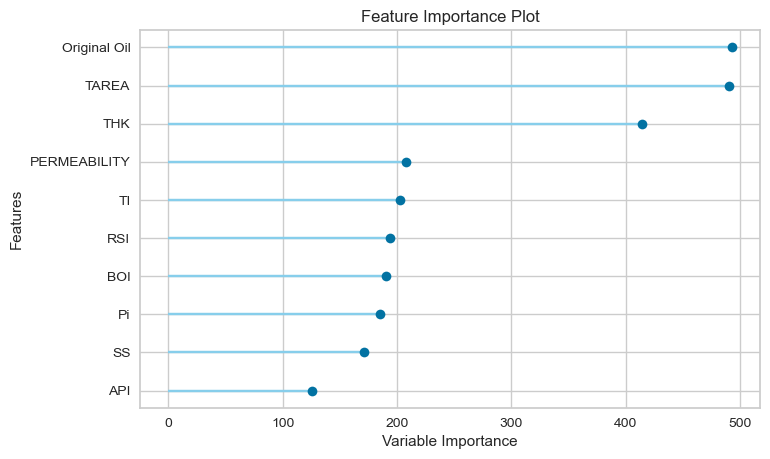

In [22]:
# Given the sheer number of variables, will only plot the first 10
# 'feature_all' will plot everything
plot_model(lgbm, plot = 'feature')

### KNN Model - note that it does not support feature importance

In [23]:
knn = create_model('knn')
knn_results = pull()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1143,0.0191,0.1382,0.0608,0.1113,1.3045
1,0.1123,0.0193,0.1390,0.0247,0.1119,1.3612
2,0.1012,0.0163,0.1277,0.1066,0.1023,1.3019
3,0.0994,0.0154,0.1239,0.1808,0.0995,1.1166
4,0.1137,0.0186,0.1362,0.0229,0.1093,1.5458
5,0.1055,0.0165,0.1285,0.2015,0.1032,1.2634
6,0.1065,0.0173,0.1315,0.1490,0.1052,1.2560
7,0.1143,0.0197,0.1404,0.0872,0.1124,1.5278
8,0.1135,0.0194,0.1394,0.0805,0.1125,1.5331
9,0.1104,0.0179,0.1337,0.1082,0.1072,1.1888


## 3. Optimisation

### a. Tune the Model

The earlier experiments allow one to determine which model performs efficiently, and the tuning needed to arrive at the answer. Here, we will create the 3 specific models , which we will than blend, and than finally produce a "tuned" blended model based on earlier optimised parameters

In [24]:
tuned_models = []

In [25]:
rf = create_model('rf', fold = 10)
# rf = tune_model(rf, 
#                 optimize = 'R2', 
#                 n_iter = 50, 
#                 #choose_better = True, 
#                 #search_library = "tune-sklearn", 
#                 #search_algorithm="Hyperopt",
#                 #search_algorithm="Optuna",
#                 #search_algorithm="bayesian",
#                 )
tuned_models.append(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0844,0.0107,0.1037,0.4716,0.0821,0.7242
1,0.0810,0.0095,0.0972,0.5227,0.0778,0.6994
2,0.0776,0.0097,0.0983,0.4710,0.0776,0.6816
3,0.0715,0.0080,0.0896,0.5714,0.0715,0.6391
4,0.0801,0.0100,0.1000,0.4730,0.0793,0.8208
5,0.0787,0.0088,0.0941,0.5720,0.0750,0.6839
6,0.0746,0.0088,0.0937,0.5683,0.0739,0.6553
7,0.0806,0.0103,0.1017,0.5207,0.0801,0.7246
8,0.0804,0.0098,0.0989,0.5374,0.0786,0.7091
9,0.0815,0.0102,0.1012,0.4897,0.0802,0.6493


In [26]:
cb = create_model('catboost', fold = 10)
# cb = tune_model(cb, 
#                 optimize = 'R2', 
#                 n_iter = 50, 
#                 #choose_better = True,
#                 #search_library = "optuna", 
#                 #search_library = "tune-sklearn", 
#                 #search_algorithm="bayesian",
#                 #search_algorithm="hyperopt",
#                 #custom_grid = catboost_param_dists ,
#                 #early_stopping = "asha",
#                 #early_stopping_max_iters = 10,
#                 #return_tuner = False ,   
#                )

tuned_models.append(cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0723,0.0086,0.0929,0.5756,0.0739,0.5847
1,0.0714,0.0078,0.0886,0.6039,0.0707,0.5835
2,0.0709,0.0088,0.0941,0.5155,0.0738,0.5639
3,0.0645,0.0069,0.0828,0.6346,0.0654,0.5127
4,0.0722,0.0083,0.0910,0.5637,0.0719,0.5948
5,0.0731,0.0083,0.0911,0.5984,0.0718,0.6234
6,0.0678,0.0078,0.0882,0.6178,0.0695,0.5694
7,0.0725,0.0087,0.0932,0.5980,0.0730,0.5706
8,0.0709,0.0085,0.0920,0.5992,0.0729,0.5325
9,0.0724,0.0085,0.0920,0.5780,0.0727,0.5150


In [27]:
knn = create_model('knn', fold = 10)
# knn = tune_model(knn, 
#                  optimize = 'R2', 
#                  n_iter = 50, 
#                  #choose_better = True, 
#                  #search_library = "tune-sklearn", 
#                  #search_algorithm="Hyperopt",
#                  #search_algorithm="Optuna",
#                  #search_algorithm="bayesian",
#                 )
tuned_models.append(knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1143,0.0191,0.1382,0.0608,0.1113,1.3045
1,0.1123,0.0193,0.1390,0.0247,0.1119,1.3612
2,0.1012,0.0163,0.1277,0.1066,0.1023,1.3019
3,0.0994,0.0154,0.1239,0.1808,0.0995,1.1166
4,0.1137,0.0186,0.1362,0.0229,0.1093,1.5458
5,0.1055,0.0165,0.1285,0.2015,0.1032,1.2634
6,0.1065,0.0173,0.1315,0.1490,0.1052,1.2560
7,0.1143,0.0197,0.1404,0.0872,0.1124,1.5278
8,0.1135,0.0194,0.1394,0.0805,0.1125,1.5331
9,0.1104,0.0179,0.1337,0.1082,0.1072,1.1888


### b. Ensemble the Model

pycaret.regression.ensemble_model(estimator, method: str = 'Bagging', fold: Optional[Union[int, Any]] = None, n_estimators: int = 10, round: int = 4, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [28]:
prediction_model = []

In [29]:
tuned_bagged_rf = ensemble_model(estimator = rf, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0844,0.0106,0.1031,0.4770,0.0818,0.7412
1,0.0821,0.0096,0.0981,0.5138,0.0786,0.7209
2,0.0773,0.0095,0.0976,0.4782,0.0771,0.6961
3,0.0723,0.0080,0.0896,0.5716,0.0714,0.6677
4,0.0807,0.0098,0.0991,0.4827,0.0788,0.8845
5,0.0804,0.0090,0.0949,0.5642,0.0758,0.7294
6,0.0768,0.0090,0.0950,0.5562,0.0750,0.7113
7,0.0817,0.0103,0.1017,0.5211,0.0800,0.7532
8,0.0819,0.0098,0.0988,0.5380,0.0786,0.7504
9,0.0822,0.0102,0.1010,0.4913,0.0801,0.6712


In [30]:
tuned_boosted_rf = ensemble_model(estimator = rf, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0832,0.0103,0.1013,0.4950,0.0807,0.7618
1,0.0810,0.0093,0.0966,0.5283,0.0776,0.7512
2,0.0771,0.0094,0.0970,0.4846,0.0768,0.7313
3,0.0730,0.0080,0.0897,0.5708,0.0715,0.6770
4,0.0796,0.0094,0.0970,0.5043,0.0772,0.8878
5,0.0787,0.0088,0.0937,0.5752,0.0750,0.7353
6,0.0746,0.0085,0.0923,0.5812,0.0730,0.7037
7,0.0813,0.0100,0.0999,0.5379,0.0788,0.7847
8,0.0806,0.0096,0.0977,0.5479,0.0781,0.7979
9,0.0815,0.0099,0.0994,0.5068,0.0790,0.6901


In [31]:
tuned_bagged_cb = ensemble_model(estimator = cb, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0750,0.0089,0.0946,0.5602,0.0752,0.6254
1,0.0732,0.0081,0.0903,0.5885,0.0722,0.6030
2,0.0716,0.0089,0.0944,0.5122,0.0744,0.5704
3,0.0662,0.0069,0.0830,0.6325,0.0658,0.5611
4,0.0740,0.0085,0.0920,0.5543,0.0728,0.6347
5,0.0740,0.0083,0.0910,0.5995,0.0725,0.6524
6,0.0684,0.0077,0.0877,0.6216,0.0692,0.6060
7,0.0741,0.0089,0.0941,0.5897,0.0737,0.5735
8,0.0734,0.0087,0.0931,0.5900,0.0738,0.5991
9,0.0741,0.0087,0.0934,0.5650,0.0739,0.5320


In [32]:
tuned_boosted_cb = ensemble_model(estimator = cb, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0790,0.0094,0.0971,0.5367,0.0775,0.7232
1,0.0766,0.0087,0.0935,0.5585,0.0750,0.7008
2,0.0729,0.0091,0.0952,0.5033,0.0753,0.6481
3,0.0680,0.0072,0.0846,0.6185,0.0672,0.6141
4,0.0764,0.0087,0.0934,0.5410,0.0740,0.7108
5,0.0764,0.0087,0.0931,0.5807,0.0747,0.7079
6,0.0716,0.0081,0.0899,0.6027,0.0711,0.6761
7,0.0768,0.0092,0.0960,0.5735,0.0755,0.6435
8,0.0765,0.0092,0.0960,0.5639,0.0766,0.7089
9,0.0759,0.0089,0.0943,0.5563,0.0747,0.5941


In [33]:
tuned_bagged_knn = ensemble_model(estimator = knn, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1130,0.0185,0.1360,0.0899,0.1096,1.3123
1,0.1100,0.0183,0.1352,0.0769,0.1091,1.3596
2,0.1010,0.0160,0.1264,0.1249,0.1015,1.3337
3,0.0982,0.0151,0.1230,0.1931,0.0990,1.1304
4,0.1095,0.0170,0.1304,0.1053,0.1048,1.5003
5,0.1056,0.0163,0.1277,0.2114,0.1027,1.2693
6,0.1057,0.0169,0.1299,0.1702,0.1041,1.2760
7,0.1132,0.0193,0.1388,0.1072,0.1116,1.5807
8,0.1109,0.0186,0.1363,0.1213,0.1101,1.5062
9,0.1082,0.0171,0.1307,0.1483,0.1049,1.1826


In [34]:
tuned_boosted_knn = ensemble_model(estimator = knn, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1164,0.0216,0.1468,-0.0599,0.1181,1.1681
1,0.1163,0.0219,0.1480,-0.1064,0.1184,1.3874
2,0.1102,0.0196,0.1402,-0.0759,0.1120,1.3686
3,0.1113,0.0198,0.1407,-0.0552,0.1124,1.1576
4,0.1151,0.0209,0.1445,-0.1001,0.1152,1.3418
5,0.1055,0.0185,0.1361,0.1042,0.1090,1.1072
6,0.1162,0.0213,0.1461,-0.0497,0.1166,1.2449
7,0.1243,0.0248,0.1576,-0.1503,0.1255,1.6450
8,0.1217,0.0237,0.1541,-0.1236,0.1237,1.6039
9,0.1159,0.0216,0.1468,-0.0754,0.1169,1.1465


### c. Blending all Models

pycaret.regression.blend_models(
estimator_list: list, fold: Optional[Union[int, Any]] = None, round: int = 4, choose_better: bool = False, optimize: str = 'R2', weights: Optional[List[float]] = None, fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False )

In [35]:
blend_5_soft = blend_models(estimator_list = tuned_models, fold=5, optimize = 'RMSE', choose_better = False)
prediction_model.append(blend_5_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0854,0.0105,0.1025,0.4781,0.0823,0.8774
1,0.0776,0.0093,0.0965,0.4965,0.0768,0.7742
2,0.0834,0.0099,0.0995,0.5006,0.0796,0.8827
3,0.0825,0.0104,0.1020,0.5039,0.0810,0.8766
4,0.0857,0.0107,0.1032,0.4828,0.0825,0.8499
Mean,0.0829,0.0102,0.1007,0.4924,0.0804,0.8522
SD,0.0029,0.0005,0.0025,0.0101,0.0021,0.0406


In [36]:
blend_10_soft = blend_models(estimator_list = tuned_models, fold=10, optimize = 'RMSE', choose_better = False)
prediction_model.append(blend_10_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0865,0.0107,0.1036,0.4726,0.0827,0.8550
1,0.0838,0.0100,0.1002,0.4924,0.0807,0.8549
2,0.0783,0.0098,0.0990,0.4632,0.0786,0.8146
3,0.0751,0.0085,0.0921,0.5475,0.0736,0.7386
4,0.0847,0.0104,0.1018,0.4538,0.0811,0.9375
5,0.0818,0.0093,0.0967,0.5479,0.0775,0.8241
6,0.0777,0.0094,0.0971,0.5364,0.0772,0.8035
7,0.0842,0.0107,0.1036,0.5032,0.0821,0.9154
8,0.0842,0.0103,0.1016,0.5111,0.0815,0.9035
9,0.0846,0.0103,0.1013,0.4878,0.0806,0.7618


### d. Stacking all Models

pycaret.regression.stack_models(estimator_list: list, meta_model=None, meta_model_fold: Optional[Union[int, Any]] = 5, fold: Optional[Union[int, Any]] = None, round: int = 4, restack: bool = True, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [37]:
stack_5 = stack_models(estimator_list = tuned_models, meta_model = rf, fold = 5, optimize = 'RMSE', choose_better= False)
prediction_model.append(stack_5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0741,0.0089,0.0943,0.5582,0.0754,0.6612
1,0.0693,0.0083,0.0910,0.5527,0.0719,0.5549
2,0.0730,0.0086,0.0928,0.5654,0.0739,0.6627
3,0.0722,0.0087,0.0931,0.5867,0.0734,0.6330
4,0.0717,0.0089,0.0944,0.5674,0.0751,0.6160
Mean,0.0721,0.0087,0.0931,0.5661,0.0739,0.6255
SD,0.0016,0.0002,0.0012,0.0116,0.0013,0.0395


In [38]:
stack_10 = stack_models(estimator_list = tuned_models, meta_model = rf, fold = 10, optimize = 'RMSE', choose_better= False)
prediction_model.append(stack_10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0760,0.0097,0.0986,0.5220,0.0783,0.6304
1,0.0726,0.0085,0.0921,0.5715,0.0735,0.5708
2,0.0722,0.0092,0.0959,0.4967,0.0751,0.5550
3,0.0661,0.0073,0.0857,0.6083,0.0678,0.5408
4,0.0722,0.0084,0.0917,0.5571,0.0727,0.6639
5,0.0741,0.0088,0.0938,0.5745,0.0752,0.6667
6,0.0664,0.0077,0.0879,0.6200,0.0692,0.5788
7,0.0756,0.0094,0.0968,0.5660,0.0762,0.6538
8,0.0709,0.0087,0.0932,0.5889,0.0740,0.6047
9,0.0727,0.0089,0.0942,0.5575,0.0749,0.5784


In [39]:
prediction_model

[BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                    

In [40]:
for model in prediction_model:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0830,0.0103,0.1017,0.4951,0.0809,0.7425


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.295946
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.342060
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.266786
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.143042
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.284232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.290440
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.338688
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.308320
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.288672


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0826,0.0101,0.1007,0.5057,0.0801,0.7673


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.2997
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.3506
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.2492
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.1695
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.2942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.2677
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.3413
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.3283
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.2887


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0756,0.0092,0.0958,0.5523,0.0759,0.6111


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.276033
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.362393
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.257033
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.146999
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.250557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.250164
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.352364
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.344330
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.275067


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0774,0.0094,0.0969,0.5420,0.0769,0.6796


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.264234
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.378771
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.249016
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.192805
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.252343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.250502
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.343260
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.360298
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.279800


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1076,0.0170,0.1303,0.1713,0.1051,1.3828


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.24832
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.44188
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.28884
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.16988
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.26184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.18472
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.35560
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.37060
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.34532


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1153,0.0208,0.1444,-0.0168,0.1156,1.3136


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.154
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.434
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.324
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.212
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.230
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.368
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.412
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.192


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0841,0.0104,0.1021,0.4917,0.0816,0.8587


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.266996
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.369459
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.271307
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.159737
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.261049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.236491
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.355634
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.332461
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.307370


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0841,0.0104,0.1021,0.4917,0.0816,0.8587


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.266996
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.369459
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.271307
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.159737
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.261049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.236491
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.355634
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.332461
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.307370


StackingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.0748,0.0094,0.0972,0.5393,0.0771,0.5988


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.2759
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.3345
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.2292
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.1104
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.2468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.2321
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.3477
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.3481
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.3139


StackingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.0748,0.0094,0.0972,0.5393,0.0771,0.5988


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.2759
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.3345
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.2292
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.1104
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.2468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.2321
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.3477
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.3481
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.3139


From the results above, the best models are 

1. catboost
2. tuned_bagged_cb
3. stack_10
4. rf

## 4. Finalise the model

In [41]:
final_rf = finalize_model(rf)

In [42]:
final_bagged = finalize_model(tuned_bagged_cb)

In [43]:
final_cb = finalize_model(cb)

In [44]:
final_stack = finalize_model(stack_10)

## 5. Save the Model

In [45]:
save_model(final_cb, 'CatBoost_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='ORF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                          target='ORF')),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='ORF')),
                 ('fix_perfect', Remove_100(target='ORF')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fi

In [46]:
save_model(final_bagged, 'Bagged_CB_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='ORF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  BaggingRegressor(base_estimator=<catboost.core.CatBoostRegressor object at 0x000001A4A17DCD30>,
                 

In [47]:
save_model(final_stack, 'Stacked_model_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='ORF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                                                                          ccp_alpha=0.0,
                                                                          criterion='mse',
                                                                          max_depth=None,
                                           

In [48]:
save_model(final_rf, 'Rf_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='ORF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None,
                                        max_samples=None,
                             

#### 6a - Test plots to analyse Model

In [49]:
model = final_rf
predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0294,0.0014,0.0373,0.9321,0.0294,0.2470


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.2738
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.3150
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.2951
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.2457
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.2207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.1819
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.3502
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.4188
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.3119


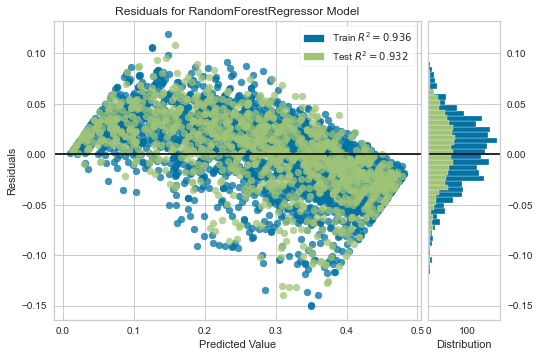

In [50]:
plot_model(model)

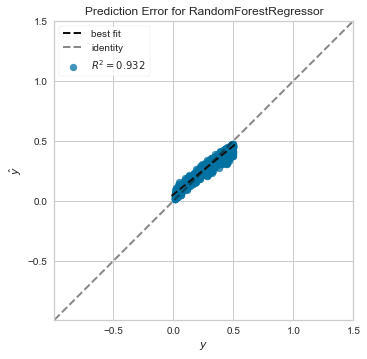

In [51]:
# Prediction Error 
plot_model(model, plot = 'error')

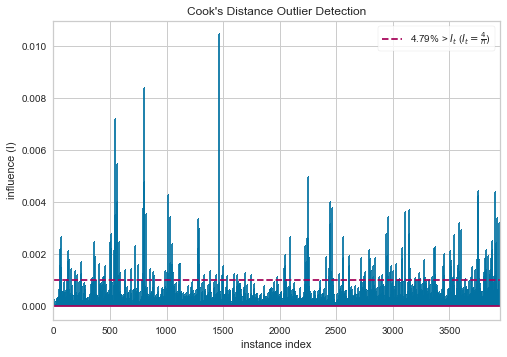

In [52]:
# Cooks Distance Plot
plot_model(model, plot='cooks')

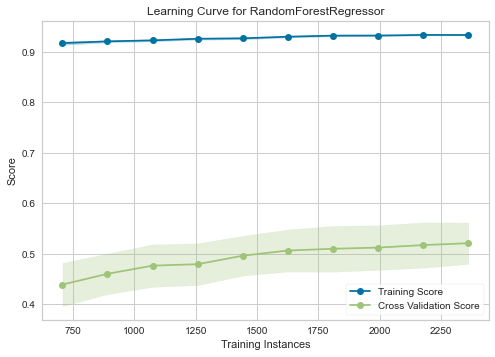

In [53]:
# Learning Curve demonstrates that a sufficiently powerful machine learning algorithm 
# (together with nicely separable data), will have no problem correctly classifying a 
# small number of data points, mainly because it will be overfitting to those few points, 
# giving a high training score but low cross-validation score. Increasing the number of points
# causes the 2 to converge because it gets harder and harder to fit a nice clean functin thro 
# all the data points

# https://scikit-learn.org/stable/modules/learning_curve.html
plot_model(model, plot='learning')

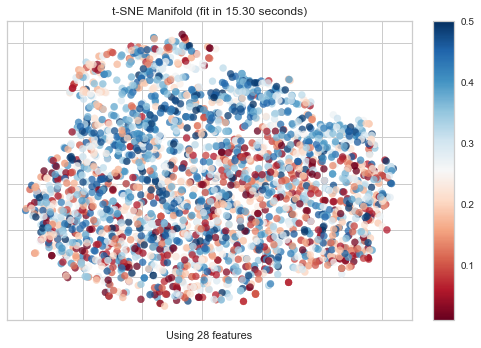

In [54]:
# Manifold Learning
plot_model(model, plot='manifold')

In [55]:
# Model Hyperparameter
plot_model(model, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mse
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None
min_samples_leaf,1


#### 6b. Test Blind Test (only on Holdout), excludes double blind test (which is in code '5_Load_Model_BlindTest')

In [56]:
dfblind = pd.read_excel("BlindTest_SSOILv2.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.head()

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF
0,MUU,6491880,7791,13.07,1040,DEP,0.31,0.20,852,3669,173.33,575,30,1.294,0.35
1,MUU,6612660,7511,23.63,633,WTR,0.26,0.33,165,3538,171.33,567,31,1.237,0.40
2,MUU,1796305,7925,14.12,380,WTR,0.26,0.27,252,5238,173.33,917,31,1.480,0.33
3,MUU,924752,10751,11.96,257,PAR,0.26,0.28,142,7315,203.33,1191,36,1.564,0.32
4,MUU,89593809,11783,74.66,3021,PAR,0.27,0.21,365,8653,220.33,1624,33,1.763,0.42


In [57]:
BlindPredict = predict_model(final_rf, data=dfblind, round=2)

In [58]:
BlindPredict

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF,Label
0,MUU,6491880,7791,13.07,1040,DEP,0.31,0.20,852,3669,173.33,575,30,1.294,0.35,0.3580
1,MUU,6612660,7511,23.63,633,WTR,0.26,0.33,165,3538,171.33,567,31,1.237,0.40,0.3916
2,MUU,1796305,7925,14.12,380,WTR,0.26,0.27,252,5238,173.33,917,31,1.480,0.33,0.3327
3,MUU,924752,10751,11.96,257,PAR,0.26,0.28,142,7315,203.33,1191,36,1.564,0.32,0.3445
4,MUU,89593809,11783,74.66,3021,PAR,0.27,0.21,365,8653,220.33,1624,33,1.763,0.42,0.4098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,PLL,248701,7044,15.67,36,PAR,0.25,0.18,397,5397,172.33,1189,34,1.623,0.45,0.4201
807,MMM,2021622,21300,15.91,752,WTR,0.22,0.16,537,13924,194.33,1171,32,1.503,0.18,0.1859
808,MUM,20619359,10315,49.82,1234,COM,0.28,0.23,410,5585,153.33,1396,30,1.785,0.36,0.3715
809,PL,1386360,15271,45.15,41,WTR,0.30,0.17,946,11850,221.33,747,18,1.238,0.48,0.4385


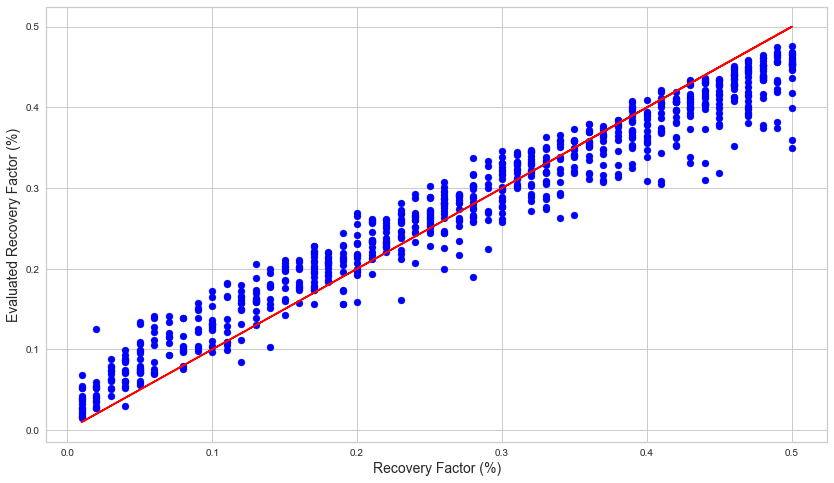

In [59]:
a = BlindPredict['ORF']
b = BlindPredict['Label']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.plot(a, a, color = 'red', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)

#plt.tight_layout()
plt.show()

In [60]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 2258.501469373703 seconds
